In [1]:
#!/usr/bin/python

import matplotlib 
matplotlib.use('Agg')

#########################GOOGLE CODE###################
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format
 
import caffe
caffe.set_device(0)
caffe.set_mode_gpu()
 
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
 
#model_path = '/Users/spiorf/Downloads/' # substitute your path here
#net_fn   = model_path + 'deploy.prototxt'
#param_fn = model_path + 'bvlc_googlenet.caffemodel'
 
    
model_path = '/Users/spiorf/Desktop/deepdream/models/googlenet_places205/' # substitute your path here
net_fn   = model_path + 'deploy_places205.protxt'
param_fn = model_path + 'googlelet_places205_train_iter_2400000.caffemodel'
     
    
    
# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))
 
net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB
 
# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])
 
def make_step(net, step_size=1.5, end='inception_4c/output', jitter=32, clip=True):
    '''Basic gradient ascent step.'''
 
    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]
 
    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
           
    net.forward(end=end)
    dst.diff[:] = dst.data  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g
 
    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
           
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)  
 
def deepdream(net, base_img, iter_n=250, octave_n=6, octave_scale=1.3, end='inception_4c/output', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
   
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)
 
        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        
        for i in xrange(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
           
            # visualization
            #
            #if not clip: # adjust image contrast if clipping is disabled
            #    vis = vis*(255.0/np.percentile(vis, 99.98))
        print octave, i, end
        showarray(deprocess(net, src.data[0]))  
        clear_output(wait=True) 
        #vis = deprocess(net, src.data[0])
        #clear_output(wait=True)
        #showarray(vis)  
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])
 
 
 
img = np.float32(PIL.Image.open('/Users/spiorf/Desktop/Scrivania/wall720.jpg'))  ##Change this to your image ###
!mkdir c:\Users\spiorf\Desktop\Scrivania\layersy
frame = img
frame_i = 0
h, w = frame.shape[:2]
s = 0.05 # scale coefficient
i = 1



Sottodirectory o file c:\Users\spiorf\Desktop\Scrivania\layersy gi… esistente.


In [2]:
blobs = net.blobs.keys()
blob_len=len(blobs)

In [3]:
for i in xrange(120):
    print i, blobs[i]

0 data
1 conv1/7x7_s2
2 pool1/3x3_s2
3 pool1/norm1
4 conv2/3x3_reduce
5 conv2/3x3
6 conv2/norm2
7 pool2/3x3_s2
8 pool2/3x3_s2_pool2/3x3_s2_0_split_0
9 pool2/3x3_s2_pool2/3x3_s2_0_split_1
10 pool2/3x3_s2_pool2/3x3_s2_0_split_2
11 pool2/3x3_s2_pool2/3x3_s2_0_split_3
12 inception_3a/1x1
13 inception_3a/3x3_reduce
14 inception_3a/3x3
15 inception_3a/5x5_reduce
16 inception_3a/5x5
17 inception_3a/pool
18 inception_3a/pool_proj
19 inception_3a/output
20 inception_3a/output_inception_3a/output_0_split_0
21 inception_3a/output_inception_3a/output_0_split_1
22 inception_3a/output_inception_3a/output_0_split_2
23 inception_3a/output_inception_3a/output_0_split_3
24 inception_3b/1x1
25 inception_3b/3x3_reduce
26 inception_3b/3x3
27 inception_3b/5x5_reduce
28 inception_3b/5x5
29 inception_3b/pool
30 inception_3b/pool_proj
31 inception_3b/output
32 pool3/3x3_s2
33 pool3/3x3_s2_pool3/3x3_s2_0_split_0
34 pool3/3x3_s2_pool3/3x3_s2_0_split_1
35 pool3/3x3_s2_pool3/3x3_s2_0_split_2
36 pool3/3x3_s2_pool3/

In [ ]:
deepdream(net, img, end=blobs[118])

1 249 inception_4c/output


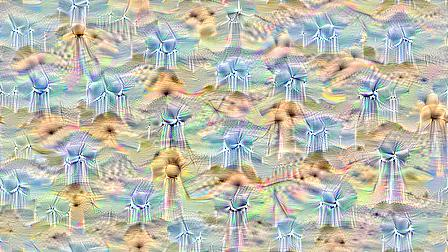

In [ ]:
i=68
while i< (len(blobs)):
    try:
            j = i+1
            frame = deepdream(net, img, end=blobs[i])
            filename = `i` + "-" + blobs[i].replace('/', '')
            PIL.Image.fromarray(np.uint8(frame)).save("/Users/spiorf/Desktop/Scrivania/layersy/%s.jpg"%filename)
            frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
            print j, str(blobs[i])
            i +=1
    except ValueError:
        print 'Skipped', str(blobs[i])
        i +=1
        pass
    except KeyError:
        print 'Skipped', str(blobs[i])
        i +=1
        pass

In [ ]:
x=120
while x >= 0:
    print   "%04d"%x, blobs[x]
    x -= 1